In [102]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

run8path = '../../../data/core-web-vitals/testrun-8'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask', 'longTasks', 'nf:init', 'nf:config', 'nf:loaded']


In [103]:
target_features = ['ttfb', 'fcp', 'tti', 'lcp']

dataset_A = pd.read_csv(f'{run8path}/results-csr.csv', sep=',')
dataset_B = pd.read_csv(f'{run8path}/results-ssrh.csv', sep=',')
dataset_C = pd.read_csv(f'{run8path}/results-ssrv-sd.csv', sep=',')

# Remove Java warmup
datasets =	{
  "csr": dataset_A.iloc[5:],
  "ssrh": dataset_B.iloc[5:],
  "ssrv": dataset_C.iloc[5:],
}

dataset_A.describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,0.00
mean,253.00,8.61,78.97,134.52,66.51,3.72,0.00,66.51,0.00,-1.00,37.92,42.99,102.33,NaN
std,145.93,6.90,13.23,12.58,8.66,6.74,0.00,8.66,0.00,0.00,8.89,9.33,9.80,NaN
min,1.00,7.00,57.00,123.40,59.20,2.60,0.00,59.20,0.00,-1.00,30.60,35.50,93.50,NaN
25%,127.00,8.00,71.00,129.80,63.10,3.00,0.00,63.10,0.00,-1.00,35.70,40.20,98.90,NaN
50%,253.00,8.00,74.00,133.10,65.80,3.20,0.00,65.80,0.00,-1.00,37.90,43.00,101.90,NaN
75%,379.00,9.00,90.00,137.50,69.00,3.60,0.00,69.00,0.00,-1.00,39.30,44.70,104.40,NaN
max,505.00,161.00,239.00,394.00,244.10,154.00,0.00,244.10,0.00,-1.00,223.40,234.30,294.40,NaN


In [104]:
def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

masks = {}
cleaned_datasets = {}

for name, df in datasets.items():
    mask = detect_outliers(df, target_features)
    masks[name] = mask
    cleaned_datasets[name] = df[mask].copy()

In [105]:
# keys = list(cleaned_datasets.keys())

# results = pd.DataFrame([
#     [metric, 'two-sided', stats.mannwhitneyu(cleaned_datasets[keys[0]][metric], 
#                                    cleaned_datasets[keys[1]][metric], 
#                                    alternative='two-sided')[1]]
#     for metric in target_features
# ], columns=['metric', 'hypothesis', 'p_value'])

# results['adjusted_p'] = multipletests(results['p_value'], method='bonferroni')[1]
# results['significant'] = results['adjusted_p'] < 0.05

# compact_format = lambda x: '%.3e' % x if x < 0.00001 else '%.5f' % x
# results['p_value'] = results['p_value'].apply(compact_format)
# results['adjusted_p'] = results['adjusted_p'].apply(compact_format)

# results

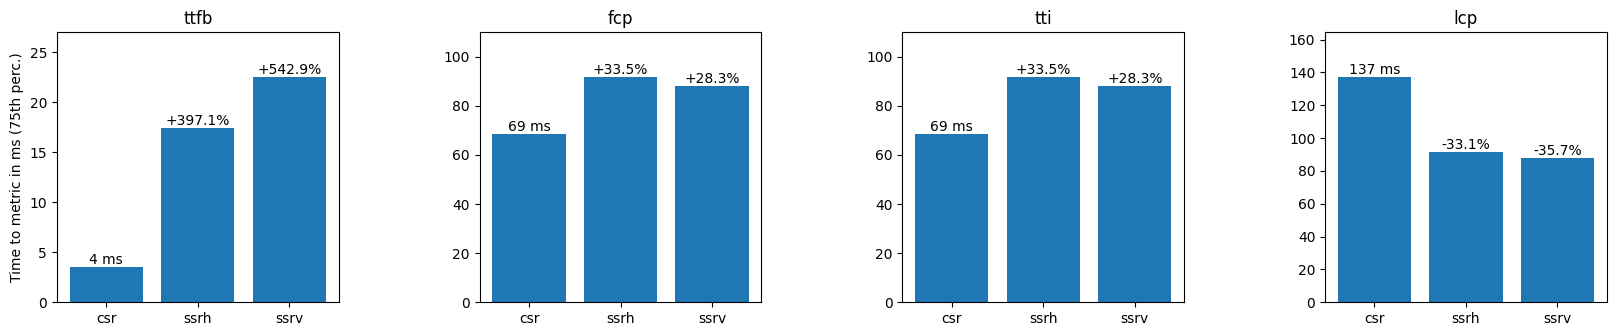

In [106]:
def plot_bar_chart(feature, loc, idx):
    percentiles = {d: cleaned_datasets[d][feature].quantile(0.75) for d in datasets}
    bars = loc.bar(percentiles.keys(), percentiles.values())
    
    baseline = list(percentiles.values())[0]
    max_height = max(percentiles.values())
    
    loc.set_ylim(0, max_height * 1.2)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = ((height / baseline) - 1) * 100
        label = f'{int(round(height, 0))} ms' if (i == 0) else f'{percentage:+.1f}%'
        loc.text(bar.get_x() + bar.get_width()/2., height,
                label,
                ha='center', va='bottom')
    
    loc.set_title(feature)
    if idx==0:
        loc.set_ylabel('Time to metric in ms (75th perc.)')

def graphs(plot_func, features, height=3):
    cols = len(features)
    _, axes = plt.subplots(ncols=cols, figsize=(20, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.5, top=0.95, bottom=0.05)
    for y, f in enumerate(features):
        plot_func(f, axes[y], idx=y)
    return plt

graphs(plot_bar_chart, ['ttfb', 'fcp', 'tti', 'lcp'])
plt.show()

In [107]:
target_features = ['tbt','ttfb', 'fcp', 'tti', 'lcp']

dataset_A = pd.read_csv(f'{run8path}/results-csr-throttled.csv', sep=',')
dataset_B = pd.read_csv(f'{run8path}/results-ssrh-throttled.csv', sep=',')
dataset_C = pd.read_csv(f'{run8path}/results-ssrv-sd-throttled.csv', sep=',')

# Remove Java warmup
datasets =	{
  "csr": dataset_A.iloc[5:],
  "ssrh": dataset_B.iloc[5:],
  "ssrv": dataset_C.iloc[5:],
}

dataset_A.describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,0.00
mean,253.00,335.37,3806.38,4541.69,1130.28,339.63,34.89,3774.99,1.00,84.89,1340.39,1680.72,3818.53,NaN
std,145.93,3.71,21.08,21.32,8.86,3.37,1.44,13.75,0.00,1.44,8.89,12.07,12.78,NaN
min,1.00,320.00,3740.00,4460.00,1101.70,325.20,32.00,3720.80,1.00,82.00,1309.40,1636.00,3770.50,NaN
25%,127.00,335.00,3790.00,4529.10,1126.10,339.70,34.00,3768.40,1.00,84.00,1336.40,1673.70,3813.10,NaN
50%,253.00,336.00,3807.00,4545.70,1129.10,339.90,35.00,3776.30,1.00,85.00,1339.30,1681.50,3819.50,NaN
75%,379.00,337.00,3824.00,4553.90,1135.90,340.30,36.00,3783.20,1.00,86.00,1345.80,1688.00,3826.10,NaN
max,505.00,344.00,3856.00,4585.00,1160.30,347.80,42.00,3809.80,1.00,92.00,1366.70,1709.10,3856.00,NaN


In [108]:
def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

masks = {}
cleaned_datasets = {}

for name, df in datasets.items():
    mask = detect_outliers(df, target_features)
    masks[name] = mask
    cleaned_datasets[name] = df[mask].copy()

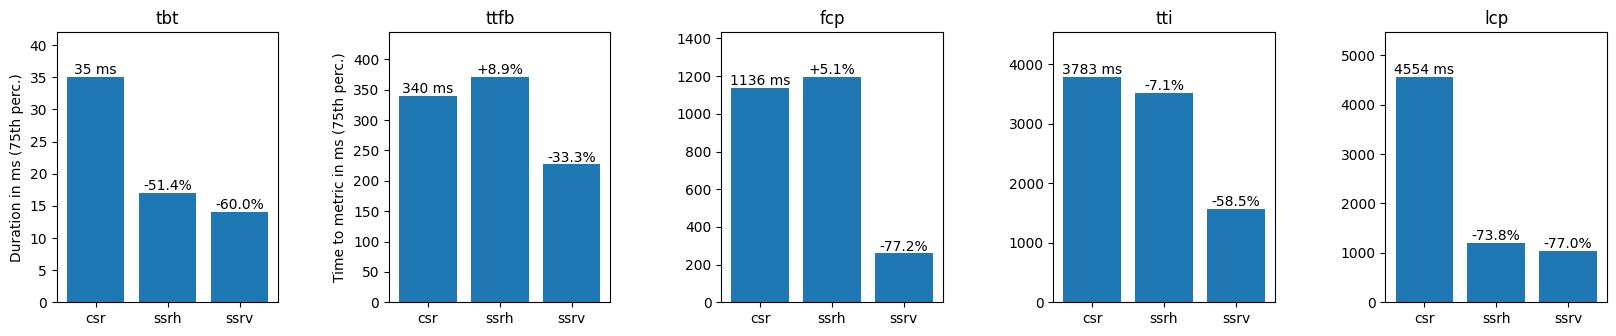

In [109]:
def plot_bar_chart(feature, loc, idx):
    percentiles = {d: cleaned_datasets[d][feature].quantile(0.75) for d in datasets}
    bars = loc.bar(percentiles.keys(), percentiles.values())
    
    baseline = list(percentiles.values())[0]
    max_height = max(percentiles.values())
    
    loc.set_ylim(0, max_height * 1.2)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = ((height / baseline) - 1) * 100
        label = f'{int(round(height, 0))} ms' if (i == 0) else f'{percentage:+.1f}%'
        loc.text(bar.get_x() + bar.get_width()/2., height,
                label,
                ha='center', va='bottom')
    
    loc.set_title(feature)
    if idx==0:
        loc.set_ylabel('Duration in ms (75th perc.)')
    if idx==1:
        loc.set_ylabel('Time to metric in ms (75th perc.)')

def graphs(plot_func, features, height=3):
    cols = len(features)
    _, axes = plt.subplots(ncols=cols, figsize=(20, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.5, top=0.95, bottom=0.05)
    for y, f in enumerate(features):
        plot_func(f, axes[y], idx=y)
    return plt

graphs(plot_bar_chart, target_features)
plt.show()

In [114]:
target_features = ['tbt','ttfb', 'fcp', 'tti', 'lcp']

dataset_A = pd.read_csv(f'{run8path}/results-csr-throttled-heavy.csv', sep=',')
dataset_B = pd.read_csv(f'{run8path}/results-ssrh-throttled-heavy.csv', sep=',')
dataset_C = pd.read_csv(f'{run8path}/results-ssrv-sd-throttled-heavy.csv', sep=',')

# Remove Java warmup
datasets =	{
  "csr": dataset_A.iloc[5:],
  "ssrh": dataset_B.iloc[5:],
  "ssrv": dataset_C.iloc[5:],
}

dataset_C.describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,505.00,0.00
mean,253.00,179.75,6017.39,1065.21,333.61,227.26,166.25,6000.88,2.85,163.80,-1.00,-1.00,-1.00,NaN
std,145.93,5.41,17.43,39.92,18.95,5.21,5.18,17.28,0.39,3.49,0.00,0.00,0.00,NaN
min,1.00,171.00,5975.00,988.00,293.20,219.10,156.00,5961.10,2.00,156.00,-1.00,-1.00,-1.00,NaN
25%,127.00,179.00,6007.00,1021.30,319.30,226.70,163.00,5990.20,3.00,161.00,-1.00,-1.00,-1.00,NaN
50%,253.00,180.00,6017.00,1085.60,336.40,227.30,165.00,6000.30,3.00,163.00,-1.00,-1.00,-1.00,NaN
75%,379.00,181.00,6027.00,1101.00,345.50,228.20,169.00,6010.90,3.00,166.00,-1.00,-1.00,-1.00,NaN
max,505.00,291.00,6180.00,1191.90,508.60,333.70,196.00,6155.70,4.00,185.00,-1.00,-1.00,-1.00,NaN


In [111]:
def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

masks = {}
cleaned_datasets = {}

for name, df in datasets.items():
    mask = detect_outliers(df, target_features)
    masks[name] = mask
    cleaned_datasets[name] = df[mask].copy()

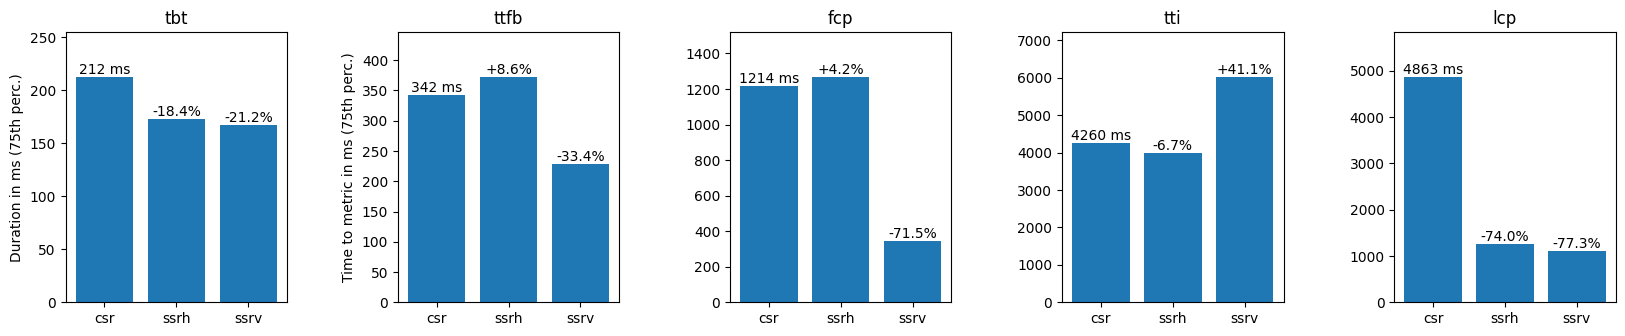

In [112]:
def plot_bar_chart(feature, loc, idx):
    percentiles = {d: cleaned_datasets[d][feature].quantile(0.75) for d in datasets}
    bars = loc.bar(percentiles.keys(), percentiles.values())
    
    baseline = list(percentiles.values())[0]
    max_height = max(percentiles.values())
    
    loc.set_ylim(0, max_height * 1.2)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = ((height / baseline) - 1) * 100
        label = f'{int(round(height, 0))} ms' if (i == 0) else f'{percentage:+.1f}%'
        loc.text(bar.get_x() + bar.get_width()/2., height,
                label,
                ha='center', va='bottom')
    
    loc.set_title(feature)
    if idx==0:
        loc.set_ylabel('Duration in ms (75th perc.)')
    if idx==1:
        loc.set_ylabel('Time to metric in ms (75th perc.)')

def graphs(plot_func, features, height=3):
    cols = len(features)
    _, axes = plt.subplots(ncols=cols, figsize=(20, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.5, top=0.95, bottom=0.05)
    for y, f in enumerate(features):
        plot_func(f, axes[y], idx=y)
    return plt

graphs(plot_bar_chart, target_features)
plt.show()